# <div style="text-align: center; color: #1a5276;">Training</div>

## <font color='blue'>  Table of Contents </font>

1. [Introduction](#1)
2. [Setup](#2)
3. [Helper Functions](#3) 
4. [Data](#4) 
5. [Model](#5)
6. [Training](#6) <br>
    6.1. [Basic Training](#6.1) <br>
    6.2. [Including a progress bar](#6.2) <br>
    6.3. [Including a validation set and a custom metric](#6.3) <br>
7. [References](#references)

<a name="1"></a>
## <font color='blue'> 1. Introduction </font>

This notebook provides a step-by-step guide to building custom training loops in PyTorch. We'll cover essential elements like forward passes, loss computation, backpropagation, and parameter updates. The goal is to create a clear and reusable structure that can be adapted for various deep learning tasks.

<a name="2"></a>
## <font color='blue'> 2. Setup </font>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.nn.functional as F

In [2]:
# seed
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
    torch.backends.cudnn.benchmark = False      # Disables auto-tuning for convolutions (better reproducibility)

set_seed(42)


<a name="3"></a>
## <font color='blue'> 3. Helper Functions </font>

In [3]:
# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

        
# plot metrics
def plot_metrics(metrics):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(metrics['train_loss'], label='Train Loss')
    plt.plot(metrics['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(metrics['train_metric'], label='Train Metric')
    plt.plot(metrics['val_metric'], label='Val Metric')
    plt.title('Metric Over Epochs')
    plt.legend()

    plt.show()

<a name="4"></a>
## <font color='blue'> 4. Data </font>

Get data:

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.MNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.MNIST('./data', train=False, transform=transform, download=True)

We will Dataset and dataloader

The Dataset and DataLoader classes encapsulate the process of pulling your data from storage and exposing it to your training loop in batches.

The Dataset is responsible for accessing and processing single instances of data.

The DataLoader:
- Pulls instances of data from the Dataset (either automatically or with a sampler that you define).
- Collects them in batches.
- Returns them for consumption by your training loop. 

The DataLoader works with all kinds of datasets, regardless of the type of data they contain.


In [6]:
# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=32, shuffle=False)

In [7]:
# Class labels
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


1  2  8  5


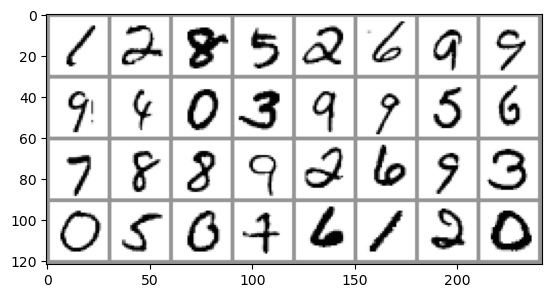

In [8]:
# plot a batch of images

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

<a name="5"></a>
## <font color='blue'> 5. Model </font>

In [9]:
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the input
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No softmax needed for logits (handled in loss function)
        return x

In [10]:
model = MNISTModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

<a name="6"></a>
## <font color='blue'> 6. Training </font>

We'll start with a basic training loop and progressively add features like validation metrics, custom metrics, and progress tracking with tqdm.

In the following figure you can see the basic steps for training:

<br>


<img src="images/Training_Loop.png"/>


<a name="6.1"></a>
### <font color='#1f618d'> 6.1. Basic Training </font>

In [11]:
# train for one epoch
def train(model, train_loader, criterion, optimizer):
    model.train()  # Set the model to training mode
    running_loss = 0.0  # Track the cumulative loss
    
    for i, data in enumerate(train_loader):  # Iterate through the data batches
        inputs, labels = data  # Unpack the inputs and labels
        
        # Zero the gradients to avoid accumulation
        optimizer.zero_grad()  
        
        # Forward pass
        outputs = model(inputs)  
        
        # Compute the loss
        loss = criterion(outputs, labels) 
        
        # Backward pass (compute gradients)
        loss.backward()  
        
        # Update model parameters
        optimizer.step()  

        running_loss += loss.item()  # Accumulate the loss
        if i % 1000 == 999:  # Print loss every 1000 batches
            last_loss = running_loss / 1000  # Average loss for the last 1000 batches
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.0  # Reset the running loss


In the previous code:

**running_loss** accumulates the loss per batch as the loop iterates.

The key detail is that running_loss is continuously summed across batches. Every 1000 batches, it's averaged to compute last_loss, which represents the average loss over those 1000 batches.

So:

- loss.item() → Loss for the current batch
- running_loss → Accumulates batch losses
- last_loss → Average loss for the last 1000 batches

In [12]:
# Let's train
for epoch in range(2):
     train(model, training_loader, criterion, optimizer)

  batch 1000 loss: 0.4308867272734642
  batch 1000 loss: 0.17801475805323572


We can combine both loops in one function:

In [13]:
model = MNISTModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
# train
def train(model, train_loader, criterion, optimizer, epochs=2):
    
    for epoch in range(epochs):  
        
        model.train()  # Set the model to training mode
        running_loss = 0.0  # Track the cumulative loss

        for i, data in enumerate(train_loader):  # Iterate through the data batches
            inputs, labels = data  # Unpack the inputs and labels

            optimizer.zero_grad()  # Zero the gradients to avoid accumulation
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backward pass (compute gradients)
            optimizer.step()  # Update model parameters

            running_loss += loss.item()  # Accumulate the loss
            if i % 1000 == 999:  # Print loss every 1000 batches
                last_loss = running_loss / 1000  # Average loss for the last 1000 batches
                print('  batch {} loss: {}'.format(i + 1, last_loss))
                running_loss = 0.0  # Reset the running loss

In [15]:
train(model, training_loader, criterion, optimizer, epochs=2)

  batch 1000 loss: 0.46684618774801495
  batch 1000 loss: 0.18747877179831265


<a name="6.2"></a>
### <font color='#1f618d'> 6.2. Including a progress bar </font>

In [16]:
model = MNISTModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
from tqdm import tqdm  # Import tqdm for the progress bar


def train(model, train_loader, criterion, optimizer, epochs=2):
    
    for epoch in range(epochs):  
        
        model.train()  # Set the model to training mode
        running_loss = 0.0  # Track the cumulative loss

        # Wrap train_loader with tqdm to show progress
        for i, data in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1} Progress")):
            inputs, labels = data  # Unpack the inputs and labels

            optimizer.zero_grad()  # Zero the gradients to avoid accumulation
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backward pass (compute gradients)
            optimizer.step()  # Update model parameters

            running_loss += loss.item()  # Accumulate the loss
            if i % 1000 == 999:  # Print loss every 1000 batches
                last_loss = running_loss / 1000  # Average loss for the last 1000 batches
                print('  batch {} loss: {}'.format(i + 1, last_loss))
                running_loss = 0.0  # Reset the running loss
                

train(model, training_loader, criterion, optimizer, epochs=2)


Epoch 1 Progress:  54%|██████████████████████████████████████████████████████████████▌                                                     | 1012/1875 [00:08<00:07, 120.11it/s]

  batch 1000 loss: 0.4437784897759557


Epoch 2 Progress:  54%|██████████████████████████████████████████████████████████████▉                                                     | 1017/1875 [00:09<00:08, 103.56it/s]

  batch 1000 loss: 0.17412054287269713


Epoch 2 Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:19<00:00, 97.70it/s]


<a name="6.3"></a>
### <font color='#1f618d'> 6.3. Including a validation set and a custom metric</font>

In [45]:
model = MNISTModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [46]:
# accuracy
def accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    return (predicted == labels).sum() / labels.size(0)

In [47]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs=10, metric_fn=None):
    device = next(model.parameters()).device  # Get device (CPU or GPU) from model parameters
    metrics = {'train_loss': [], 'val_loss': [], 'train_metric': [], 'val_metric': []}  # Store history of losses and metrics

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        total_loss = 0.0  # Accumulate total weighted training loss
        total_metric = 0.0  # Accumulate total weighted training metric
        total_samples = 0  # Total number of training samples processed

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to device

            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss for batch
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model weights

            batch_size = labels.size(0)
            loss_value = loss.item()
            total_loss += loss_value * batch_size  # Accumulate weighted loss by batch size

            if metric_fn:
                metric_value = metric_fn(outputs, labels).item()
                total_metric += metric_value * batch_size  # Accumulate weighted metric by batch size
            total_samples += batch_size  # Update total number of training samples processed

        avg_loss = total_loss / total_samples  # Average loss per sample over the epoch
        avg_metric = total_metric / total_samples if metric_fn else 0  # Average metric per sample over the epoch
        metrics['train_loss'].append(avg_loss)  # Save training loss history
        metrics['train_metric'].append(avg_metric)  # Save training metric history

        model.eval()  # Set model to evaluation mode
        val_total_loss = 0.0  # Accumulate total weighted validation loss
        val_total_metric = 0.0  # Accumulate total weighted validation metric
        val_total_samples = 0  # Total validation samples processed

        with torch.no_grad():  # Disable gradients during validation for efficiency
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move validation batch to device
                outputs = model(inputs)  # Forward pass
                vloss = criterion(outputs, labels)  # Compute validation loss for batch

                batch_size = labels.size(0)
                val_total_loss += vloss.item() * batch_size  # Accumulate weighted val loss

                if metric_fn:
                    vmetric = metric_fn(outputs, labels).item()
                    val_total_metric += vmetric * batch_size  # Accumulate weighted val metric
                val_total_samples += batch_size  # Update validation samples count

        avg_val_loss = val_total_loss / val_total_samples  # Average validation loss per sample
        avg_val_metric = val_total_metric / val_total_samples if metric_fn else 0  # Average validation metric
        metrics['val_loss'].append(avg_val_loss)  # Save validation loss history
        metrics['val_metric'].append(avg_val_metric)  # Save validation metric history

        # Print epoch progress
        print(f'Epoch {epoch + 1} - Train Loss: {avg_loss:.4f}, Train Metric: {avg_metric:.4f}, '
              f'Val Loss: {avg_val_loss:.4f}, Val Metric: {avg_val_metric:.4f}')

    return metrics  # Return dictionary with recorded losses and metrics over epochs


In [48]:
# Example training loop
metrics = train(model, training_loader, validation_loader, criterion, optimizer, epochs=5, metric_fn=accuracy)

Epoch 1 - Train Loss: 0.3441, Train Metric: 0.8966, Val Loss: 0.1948, Val Metric: 0.9378
Epoch 2 - Train Loss: 0.1603, Train Metric: 0.9503, Val Loss: 0.1234, Val Metric: 0.9613
Epoch 3 - Train Loss: 0.1201, Train Metric: 0.9635, Val Loss: 0.1300, Val Metric: 0.9611
Epoch 4 - Train Loss: 0.0990, Train Metric: 0.9690, Val Loss: 0.1279, Val Metric: 0.9598
Epoch 5 - Train Loss: 0.0866, Train Metric: 0.9724, Val Loss: 0.1100, Val Metric: 0.9650


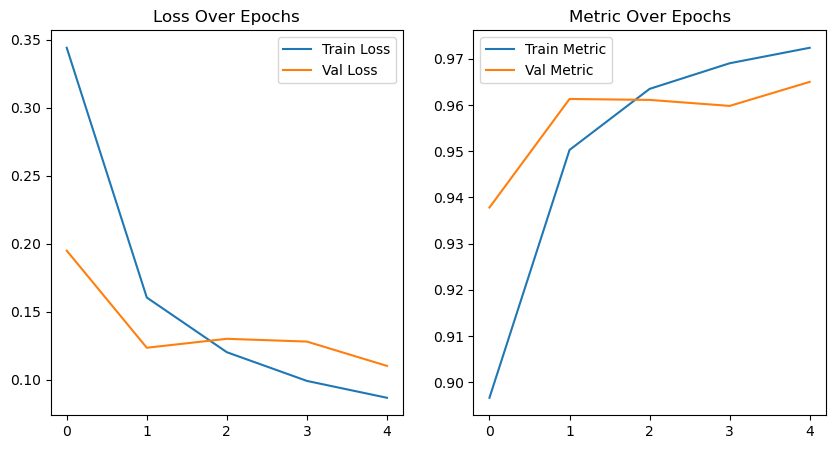

In [49]:
plot_metrics(metrics)

Note that for validation, we set the model to evaluation mode (model.eval()). This is crucial for models that behave differently during training and inference, such as those with dropout or batch normalization (e.g., dropout is disabled, and batch normalization uses running statistics instead of batch statistics).

- running loss (called total_loss there) is the sum of the loss values for every individual sample processed during the epoch. It accumulates each batch’s average loss multiplied by that batch’s size — so it represents the total loss over all samples seen so far.

- avg_loss is the average loss per sample over the entire epoch. It’s computed by dividing the total_loss by the total number of samples processed (total_samples). This gives a normalized metric that represents the model’s typical loss on a single example across the whole epoch.

| Variable     | Meaning                               | Interpretation                       |
| ------------ | ------------------------------------- | ------------------------------------ |
| `total_loss` | Sum of all individual sample losses   | Total loss accumulated over epoch    |
| `avg_loss`   | `total_loss` divided by total samples | Average loss per sample in the epoch |


**Why this matters:**
- Since batch sizes can vary (especially the last batch), just averaging batch losses directly would be misleading.
- Weighting each batch loss by its batch size before summing ensures the final average correctly reflects per-sample loss.


**<font color='#154360'>Example</font>**

| Batch | Batch Size | Batch Loss (loss.item()) | Total Loss for Batch (batch loss × batch size) |
| ----- | ---------- | ------------------------ | ---------------------------------------------- |
| 1     | 4          | 0.5                      | 0.5 × 4 = 2.0                                  |
| 2     | 2          | 1.0                      | 1.0 × 2 = 2.0                                  |

**Calculations**
- total_loss = sum of batch total losses = 2.0 + 2.0 = 4.0

- total_samples = 4 + 2 = 6

- avg_loss = total_loss / total_samples = 4.0 / 6 ≈ 0.6667

**Interpretation**
- total_loss (4.0) is the sum of individual losses over all 6 samples in the epoch.

- avg_loss (≈ 0.6667) is the average loss per sample across the entire epoch, properly accounting for different batch sizes.


**Why is this better than a simple average of batch losses?**
If you just averaged the batch losses without weighting:


simple_average = (0.5+1.0)/2=0.75


This overestimates the loss because it treats the smaller batch equally, even though the first batch has twice the samples.



**Note**

You multiply loss.item() by the batch size because:

- loss.item() returns the average loss per sample in that batch (since most loss functions use reduction='mean' by default).

- To get the total loss summed over all samples in the batch, you multiply that average by the batch size.

- This lets you accumulate the true total loss over all samples when adding across batches.

- Finally, dividing the accumulated total loss by the total number of samples gives you the correct average loss per sample for the entire epoch.

In short:

- Multiply by batch size → get total loss per batch
- Sum over batches → total loss over all samples
- Divide by total samples → average loss per sample (epoch-level)

<a name="references"></a>
## <font color='blue'> References </font>

[PyTorch Documentation](https://pytorch.org/docs/stable/index.html)

[IBM Deep Learning with PyTorch](https://www.coursera.org/learn/advanced-deep-learning-with-pytorch?specialization=ibm-deep-learning-with-pytorch-keras-tensorflow)
